# A script for analysing past interannual variability in the Ilyas dataset

Dataset used: 

_Ilyas, M., Brierley, C.M. and Guillas, S., 2017. Uncertainty in regional temperatures inferred from sparse global observations: Application to a probabilistic classification of El Niño. Geophysical Research Letters, 44(17), pp.9068-9074._

Code written by Jarmo Kikstra



Runtime of current [full] analysis on 'median.nc' ~= 15 seconds 
Runtime of current analysis on just 10 members ~= 360 seconds (6 minutes)

Note: a change in the datasets:

        xxxx.ann_ensmem.wrt_18501900.nc goes up til 2018

        xxxx.ann_ensmem.wrt18501900.nc still goes up til 2016

In [46]:
import numpy as np
import matplotlib.pyplot as plt
#from netCDF4 import Dataset # remove in final version if not actually used.
import pandas as pd
import xarray as xr
import math
from scipy import stats
import pylab
import seaborn as sns


startyr = 1850
endyr = 2018
climateperiod = 31
halfclimperiod = np.floor(climateperiod)
numyears_data = endyr - startyr + 1

#scipy.signal.detrend

In [5]:
# NB. requires an install every time I activate pangeo again on a UCLgeogLinux system;
# testing if uncertainties was properly imported.
import uncertainties as u  
from uncertainties import ufloat
from uncertainties.umath import *
x = ufloat(1, 0.01)
print(x*2)


2.000+/-0.020


## PAGE-ICE masking functions

### The regions as defined in PAGE-ICE

In [6]:
# Mapping is conform data provided for PAGE-ICE documentation.
regions = {
    1 : 'eu',
    2 : 'rus+',
    3 : 'usa',
    4 : 'chi+',
    5 : 'ind+',
    6 : 'afr',
    7 : 'lat',
    8 : 'oth'    
}
# some parameters to increase readability of the code:
numregions = len(regions)

### Setting up directory and selecting maskig file

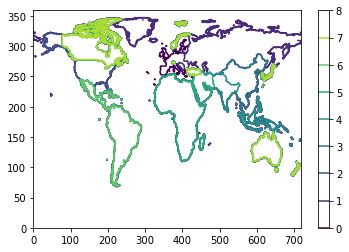

In [7]:
# DOCUMENTATION:
# naming convention:
## grid = Ilyas 36x72 grid
## mask / fullmask = 180 x 360 

# load pagemask.nc file using xarray
dsdir = 'TemperatureVariability/'
dsname = 'pagemask.nc'
DS = xr.open_dataset(dsdir + dsname)
da = DS.world # select variable
mask = da.values # turn dataset into numpy array
    # NB.... mask.shape != grid.shape....

#np.place(mask, mask<1, np.nan)
plt.contour(mask)
plt.colorbar()

### Take original masking set and translate it to 8 separate masking sets (still the original high resolution) 

In [11]:
# global variables used:
# - regions

# make 8 separate 1-0 masks, full resolution
def create_separate_masks(fullmask):
    maskingset = np.zeros((len(regions),fullmask.shape[0],fullmask.shape[1]))
    for k in range (1,len(regions)+1):
        for ii in range(fullmask.shape[0]):
            for jj in range(fullmask.shape[1]):
                if fullmask[ii][jj] == k:
                    
                    maskingset[k-1][ii][jj] = 1

    return maskingset

maskingset = create_separate_masks(mask)

### Function for applying PAGE-masks to a dataset, returning dataset as 3d matrix with (coarse) coastally weighted data per gridpoint, with a dimension for every region.

In [17]:
# global variables used:
# - regions, 
# - mask, 
# - maskingset


# now, for eventual calculations, we don't create a 1/0 masking set, but rather just a weighted grid!! 

def create_weighted_grids(grid): # grid should be input of 36 x 72 (so for 1 time entry!!)
    weighted_grid = np.zeros((len(regions), grid.shape[0],grid.shape[1]))
    iratio = int(mask.shape[0]/grid.shape[0]) # = 10
    jratio = int(mask.shape[1]/grid.shape[1]) # = 10
    
    # on the t_anom grid.
    for k in range(len(regions)):
        for i in range(grid.shape[0]): # latitude
            for j in range(grid.shape[1]): # longitude
                weighted_grid[k][i][j] = np.mean(maskingset[k, i*iratio:(i*iratio+iratio), j*jratio:(j*jratio+jratio)]) # ratios of scaling
#                 if weighted_grid[k][i][j] == 0.:
#                     weighted_grid[k][i][j] = np.nan
    return weighted_grid        


## Reading and manipulating data for analysis

### For Median Only

#### Loading data

In [18]:
# load the medians of the temperature anomalies from the datafile
dsdir = '/data/aod/Ilyasetal2017_annual/wrt_18501900/'
dsname = 'ensemble_statistics.ann_wrt_18501900.nc' #'median.nc'
DS = xr.open_dataset(dsdir + dsname, decode_times=False)
t_anom_ds = DS['median']     # yearly data; [167 x 36 x 72], float32
t_anom = t_anom_ds.values

6.1482916 -4.3221416
(169, 36, 72)
(8, 36, 72)


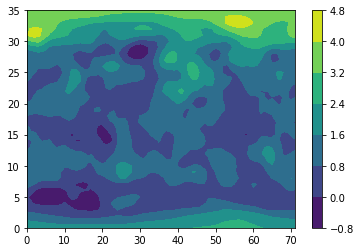

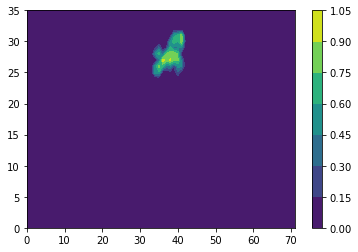

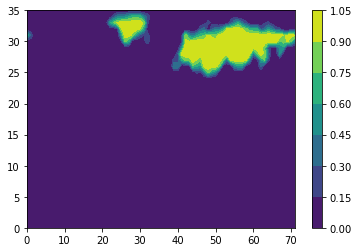

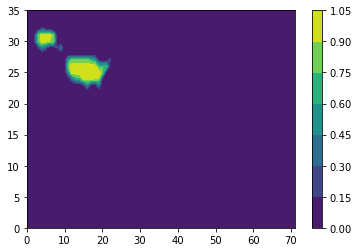

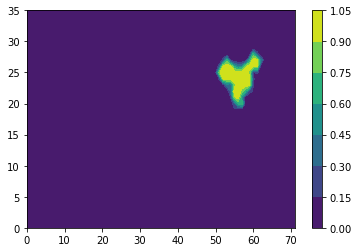

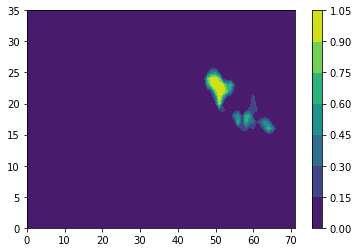

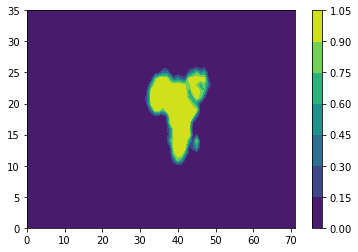

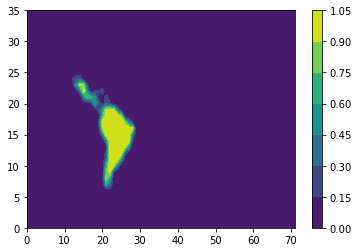

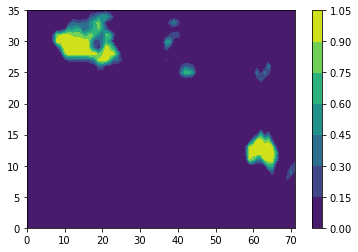

In [19]:
## Some visualisation and checking of the data loaded above:

# print some data to show some characteristic features of the dataset
print(t_anom.max(), t_anom.min())
print(t_anom.shape)

# for visualisation, plot warming pattern in the last (167th) year of analysis (currently 2016)
plt.contourf(t_anom[168])
plt.colorbar()

# call function that applies the page-ice mask and plot its result, 
## with t_anom just serving to provide info on dimensions of the data that is being analysed
weighted_grid = create_weighted_grids(t_anom[1][:][:]) # t_anom only given as argument to get the dimensions of the grid
print(weighted_grid.shape)
# check representation of continents
for i in regions:
    plt.figure()
    plt.contourf(weighted_grid[i-1])
    plt.colorbar()

# Performing analysis

### Create regional mean data, now including area weighting

In [10]:
# area weighting for when creating means, etc.
alat = np.linspace(-87.5, 87.5, 36)
def areaweight(lat):
    degree = abs(alat[lat])
    weight = np.cos(degree*np.pi/180)
    
    return weight

In [20]:
# global variables used:
# - regions
# - weighted_grid
# - numregions
# - numyears_data
# - ...

# data = t_anom

def do_regional_data(data):
    # to check the size of the input 'data' and adjust the parameters accordingly
    if data.ndim == 3:
        numyears = data.shape[0]
        grid_lat = data.shape[1]
        grid_lon = data.shape[2]
    if data.ndim == 2:
        numyears = 1
        grid_lat = data.shape[0]
        grid_lon = data.shape[1]
    
    # create variable to store processed data:
    regional_data = np.zeros((numregions, numyears)) # for storing weighted mean temperature (per year and per region)
                              
    # apply masking weights:                           
    # N.B. below highly nested loop is very slow. Is there a quicker way using Linear Algebra?
    for c in range(numregions): # run over all regions
        for year in range(numyears): # run over all years
            t_sum = 0
            areaweights_sum = 0
            for i in range(grid_lat): 
                for j in range(grid_lon):
                    # this highly nested loop applies the weights of the masked grid to the data.
                        ## apply area weighting here
                    
                    if data.ndim == 2:
                        t_sum = t_sum + data[i][j] * weighted_grid[c][i][j]*areaweight(i)
                        areaweights_sum = areaweights_sum + weighted_grid[c][i][j]*areaweight(i)
                    else:
                        t_sum = t_sum + data[year][i][j] * weighted_grid[c][i][j]*areaweight(i)
                        areaweights_sum = areaweights_sum + weighted_grid[c][i][j]*areaweight(i)
            t_mean = t_sum/areaweights_sum
            regional_data[c][year] = t_mean     
    
    return regional_data
    
regional_data = do_regional_data(t_anom)

(1850, 2018)

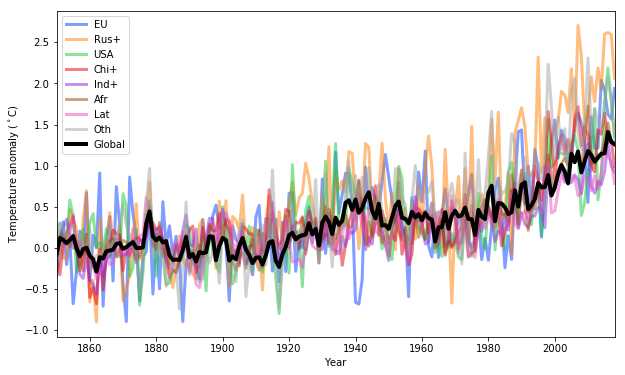

In [171]:
palette = sns.color_palette("pastel")
regionlabels = ['EU', 'Rus+', 'USA', 'Chi+', 'Ind+', 'Afr', 'Lat', 'Oth']

# check results by printing regional mean temperatures, with area weighting
plt.figure(figsize=(10, 6))
# plt.plot(range(regional_data.shape[1]), np.mean(global_data_detrended, axis=1))
global_data_plot = np.zeros(numyears_data)
for k in range(numyears_data):
    global_data_plot[k]  = np.mean(t_anom[k])

for c in range(len(regions)):
    plt.plot(range(startyr, endyr+1), regional_data[c], label = regionlabels[c], linewidth=3, alpha=.5)
plt.plot(range(startyr, endyr+1), global_data_plot, color="black", linewidth=4, label = 'Global')
plt.legend()    
plt.ylabel('Temperature anomaly ($^\circ$C)')
plt.xlabel('Year')
plt.xlim((startyr,endyr))

### Detrend a) regional mean data, and b) global mean data.
#### Done by creating a 31yr array for each year, and subtracting the trend from that climatic period. 

In [22]:
# global variables used:
# - t_anom
# - numregions
# - numyears_data
# - climateperiod
    
                    # perhaps add argument and adaptable code to specify the form of detrending
def detrend_data_and_climatic_data(regional_data):    
    
    # create variable to store processed data:
    regional_data_detrended = np.zeros((numregions, numyears_data, climateperiod)) # for storing detrended annual weighted mean temperature (with full climatic period data) (per year and per region)
    regional_data_notdetrended = np.zeros((numregions, numyears_data, climateperiod)) # for find_uncertainty()
    regional_clim_data = np.zeros((numregions, numyears_data)) # for storing non-detrended climatic data
    regional_clim_data_detrended = np.zeros((numregions, numyears_data)) # for find_uncertainty()
    
    # regional detrending
## check ceil and floor....
    for c in range(numregions):
        for k in range(numyears_data):          
            # first half period of detrended and climatic regional data will be filled with nan.
            if k < math.floor(climateperiod/2): 
                regional_data_detrended[c][k] = np.nan
                regional_clim_data[c][k] = np.nan
            # last half period of detrended and climatic regional data will be filled with nan.
            elif k >= (numyears_data - math.ceil(climateperiod/2)):
                regional_data_detrended[c][k] = np.nan
                regional_clim_data[c][k] = np.nan
            else:
                # take linear trend for every 30yr climatic period 
                # do (linear=1) fitting on the selected data [x,y,orderpolynomial]:
                selecteddatawindow = np.squeeze(regional_data[c, (k-math.floor(climateperiod/2)):(k+math.ceil(climateperiod/2))])
                fit = np.polyfit(list(range(climateperiod)), selecteddatawindow, 1)    
                f = np.poly1d(fit)              
                                
#                 # subtract fit from regional_data and put that into regional_data_detrended
#                 # for checking the detrending, do before and after scatter plots
#                 plt.figure()
#                 plt.plot(list(range(climateperiod)), f(list(range(climateperiod))))
#                 plt.scatter(list(range(climateperiod)), selecteddatawindow)
#                 plt.scatter(list(range(climateperiod)), selecteddatawindow - f(list(range(climateperiod))), c='r')
                
                regional_data_detrended[c][k][:] = selecteddatawindow - f(list(range(climateperiod)))
                regional_data_notdetrended[c][k][:] = selecteddatawindow
                
                # save climatic data
                regional_clim_data[c][k] = np.mean(selecteddatawindow)
                regional_clim_data_detrended[c][k] = np.mean(selecteddatawindow - f(list(range(climateperiod))))
                
                
                
    
    
    # global detrending 
    # create variable to store processed data:
    global_data_detrended = np.zeros((numyears_data, climateperiod))
    global_clim_data = np.zeros(numyears_data)
        
    # create the mean temperature for the globe (GMT) for every year.
    t_anom_mean = np.zeros(numyears_data)
    for k in range(numyears_data):
        t_anom_mean[k] = np.mean(t_anom[k])
    
    
    for k in range(numyears_data):
        # first half period of detrended and climatic regional data will be filled with nan.
        if k < math.floor(climateperiod/2):
            global_data_detrended[k] = np.nan
            global_clim_data[k] = np.nan
        # last half period of detrended and climatic regional data will be filled with nan.
        elif k >= (numyears_data - math.ceil(climateperiod/2)):
            global_data_detrended[k] = np.nan
            global_clim_data[k] = np.nan
        else: 
            # take linear trend for every 30yr climatic period 
            selecteddatawindow = np.squeeze(t_anom_mean[(k-math.floor(climateperiod/2)):(k+math.ceil(climateperiod/2))])
            fit = np.polyfit(list(range(climateperiod)), selecteddatawindow, 1)    
            f = np.poly1d(fit)
            
            # subtract fit from global_data and put that into global_data_detrended
            global_data_detrended[k][:] = selecteddatawindow - f(list(range(climateperiod)))
            
            # save climatic data
            global_clim_data[k] = np.mean(selecteddatawindow)
    
    
    
    
    return regional_data_detrended, global_data_detrended, regional_clim_data, global_clim_data, regional_data_notdetrended, regional_clim_data_detrended
                 
    
regional_data_detrended, global_data_detrended, regional_clim_data, global_clim_data, regional_data_notdetrended, regional_clim_data_detrended = detrend_data_and_climatic_data(regional_data)

(169, 31) (8, 169)


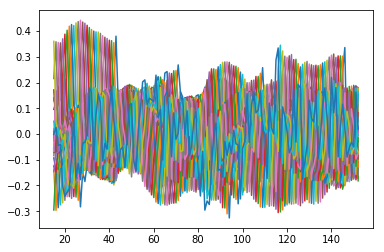

In [29]:
# print to check shape of global anomalies: for every year there are 31 entries, 
    # which are the means of the years in the climateperiod around that year  
print(global_data_detrended.shape, regional_data.shape)
global_data_detrended[14:50]
plt.plot(range(regional_data.shape[1]), global_data_detrended);

# for i in range(regional_data.shape[1]):
#     print(np.nanmean(global_data_detrended[i]))

/home/ucfajsk/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


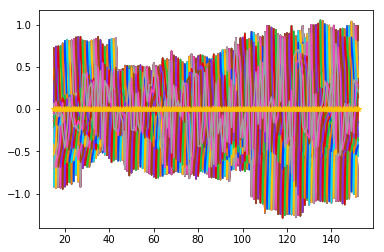

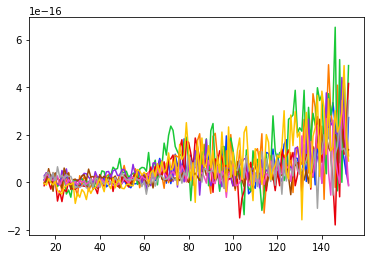

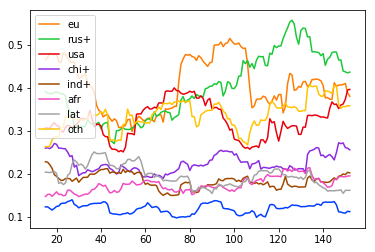

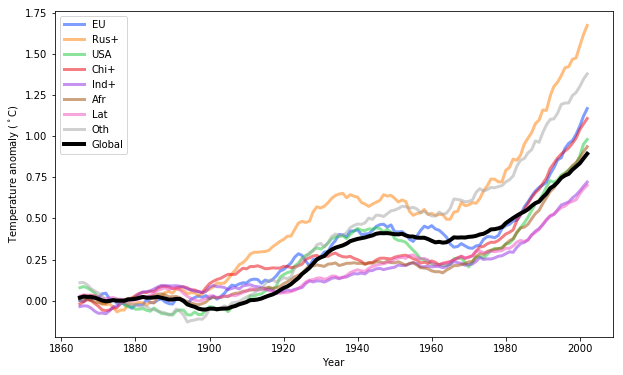

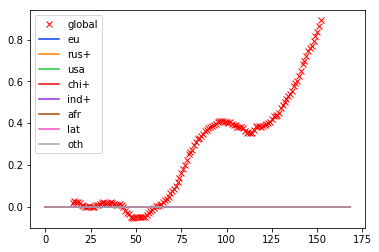

In [172]:
# check the data output:


# regional temperatures (for all 30 entries of a climateperiod at a certain year) - should be fluctuating around zero
plt.figure()
for c in range(len(regions)):
    plt.plot(range(regional_data.shape[1]), regional_data_detrended[1]) ###for eu: regional_data_detrended[region][year]
# mean of detrended global data - should be close to zero
plt.plot(range(regional_data.shape[1]), np.nanmean(global_data_detrended, axis=1), marker='*')

# means of regional temperatures - should be close to zero (or close to zero)
plt.figure()
plt.plot(range(regional_data.shape[1]), np.mean(global_data_detrended, axis=1))
for c in range(len(regions)):
    plt.plot(range(regional_data.shape[1]), np.mean(regional_data_detrended[c], axis=1))

# standard deviations:
plt.figure()
plt.plot(range(regional_data.shape[1]), np.std(global_data_detrended, axis=1))
for c in range(len(regions)):
    plt.plot(range(regional_data.shape[1]), np.std(regional_data_detrended[c], axis=1), label = regions[c+1])
plt.legend()

# climatic temperatures:
plt.figure(figsize=(10, 6))
palette = sns.color_palette("pastel", 8)
regionlabels = ['EU', 'Rus+', 'USA', 'Chi+', 'Ind+', 'Afr', 'Lat', 'Oth']


for c in range(len(regions)):
    plt.plot(range(startyr, startyr + regional_data.shape[1]), regional_clim_data[c], label = regionlabels[c], linewidth=3, alpha=.5)
plt.plot(range(startyr, startyr + regional_data.shape[1]), global_clim_data, color='black', linewidth=4, label = 'Global')
plt.legend()
plt.ylabel('Temperature anomaly ($^\circ$C)')
plt.xlabel('Year')



# detrended climatic data, which should yield basically zero for all regions:
plt.figure()
plt.plot(range(regional_data.shape[1]), global_clim_data, 'rx', label = 'global')
for c in range(len(regions)):
    plt.plot(range(regional_data.shape[1]), regional_clim_data_detrended[c], label = regions[c+1])
plt.legend()

mean SD of eu 0.40618267329976765
mean SD of rus+ 0.39844713772817464
mean SD of usa 0.3252555272522722
mean SD of chi+ 0.22547211679568047
mean SD of ind+ 0.1843145894374979
mean SD of afr 0.17492734614386948
mean SD of lat 0.19497470468919498
mean SD of oth 0.3380869320481861
global mean SD 0.11957976157382595
Thus, subtracting the mean interannual SD of the global annual temperatures, the regions will have left:
mean SD of eu 0.2866029117259417
mean SD of rus+ 0.2788673761543487
mean SD of usa 0.20567576567844625
mean SD of chi+ 0.10589235522185451
mean SD of ind+ 0.06473482786367195
mean SD of afr 0.05534758457004353
mean SD of lat 0.07539494311536903
mean SD of oth 0.21850717047436014


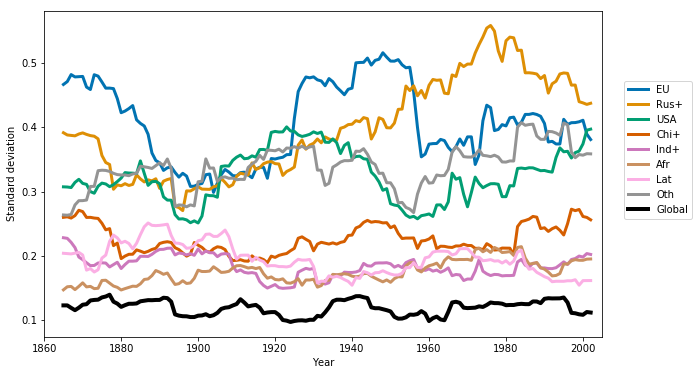

In [177]:
# global variables used:
# - startyr
# - endyr
# - regions
# - numregions
# - numyears_data

def calculate_std(regional_data_detrended, global_data_detrended):
    regional_std = np.zeros((numregions, numyears_data))
    global_std = np.zeros(numyears_data)
    for k in range(numyears_data):
        global_std[k] = np.std(global_data_detrended[k])
        for c in range(numregions):
            regional_std[c][k] = np.std(regional_data_detrended[c][k][:])
    return regional_std, global_std

regional_std, global_std = calculate_std(regional_data_detrended, global_data_detrended)

palette = sns.color_palette("colorblind", 8)
regionlabels = ['EU', 'Rus+', 'USA', 'Chi+', 'Ind+', 'Afr', 'Lat', 'Oth']


# plot standard deviations over time:
fig = plt.figure(figsize=(10, 6))

for c in range(numregions):
    plt.plot(range(startyr,endyr+1), regional_std[c], label = regionlabels[c], color=palette[c], linewidth=3)
plt.plot(range(startyr,endyr+1), global_std, label = 'Global', color='black', linewidth=4)
plt.xlim([1860,2005])
# plt.title('Standard Deviations of Interannual mean temperature (detrended for 31-yr periods)')
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.8), shadow=False, ncol=1)
plt.xlabel('Year')
plt.ylabel('Standard deviation')


    # print out mean SDs
for c in range(numregions):
    print('mean SD of ' + str(regions[c+1]) + ' ' + str(np.nanmean(regional_std[c])))
print('global mean SD' + ' ' + str(np.nanmean(global_std)))

print('Thus, subtracting the mean interannual SD of the global annual temperatures, the regions will have left:')
for c in range(numregions):
    print('mean SD of ' + str(regions[c+1]) + ' ' + str(np.nanmean(regional_std[c])-np.nanmean(global_std)))

In [33]:
def calculate_correlations(regional_std, global_std, regional_clim_data, global_clim_data):
    
    
    spearman_correlations_regional_rmt = np.zeros((len(regions),2))
    pearson_correlations_regional_rmt = np.zeros((len(regions),2))
    anova_ftest_regional_rmt = np.zeros((len(regions),2))
    for c in range(numregions):
        # temporarily get rid of nan entries:
        A = regional_std[c][~np.isnan(regional_std[c])]
        B = regional_clim_data[c][~np.isnan(regional_clim_data[c])]
        # use different statistical techniques (these should probably be made more robust):
        spearman_correlations_regional_rmt[c] = stats.spearmanr(A,B) # stats.spearmanr(A,B) -- takes: two arrays -- returns: correlation, p-value || The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
        pearson_correlations_regional_rmt[c] = stats.pearsonr(A,B) # stats.pearsonr(A,B) -- takes: two arrays -- returns: correlation, p-value || The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
        anova_ftest_regional_rmt[c] = stats.f_oneway(A,B) # stats.f_oneway(A,B) -- takes: two arrays -- returns: f-value, p-value || The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid. 1) The samples are independent. 2) Each sample is from a normally distributed population. 3) The population standard deviations of the groups are all equal. This property is known as homoscedasticity.
    
    spearman_correlations_regional_gmt = np.zeros((len(regions),2))
    pearson_correlations_regional_gmt = np.zeros((len(regions),2))
    anova_ftest_regional_gmt = np.zeros((len(regions),2))
    for c in range(numregions):
        # temporarily get rid of nan entries:
        A = regional_std[c][~np.isnan(regional_std[c])]
        B = global_clim_data[~np.isnan(global_clim_data)]
        # use different statistical techniques (these should probably be made more robust):
        spearman_correlations_regional_gmt[c] = stats.spearmanr(A,B) # stats.spearmanr(A,B) -- takes: two arrays -- returns: correlation, p-value || The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
        pearson_correlations_regional_gmt[c] = stats.pearsonr(A,B) # stats.pearsonr(A,B) -- takes: two arrays -- returns: correlation, p-value || The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.
        anova_ftest_regional_gmt[c] = stats.f_oneway(A,B) # stats.f_oneway(A,B) -- takes: two arrays -- returns: f-value, p-value || The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid. 1) The samples are independent. 2) Each sample is from a normally distributed population. 3) The population standard deviations of the groups are all equal. This property is known as homoscedasticity.
    
    print(spearman_correlations_regional_rmt)
    print(pearson_correlations_regional_rmt)
    print(anova_ftest_regional_rmt)
    print(spearman_correlations_regional_gmt)
    print(pearson_correlations_regional_gmt)
    print(anova_ftest_regional_gmt)
        
calculate_correlations(regional_std, global_std, regional_clim_data, global_clim_data)



[[ 2.27181505e-01  7.37024627e-03]
 [ 7.53340837e-01  1.58686195e-26]
 [ 3.96414065e-01  1.48573907e-06]
 [ 2.71018222e-01  1.30363919e-03]
 [-1.85541189e-01  2.93506724e-02]
 [ 6.24666373e-01  2.66863676e-16]
 [-5.71482389e-01  2.47753816e-13]
 [ 5.18837231e-01  7.07615054e-11]]
[[ 1.79737244e-01  3.49066651e-02]
 [ 6.98134418e-01  1.78899145e-21]
 [ 3.83054770e-01  3.53388732e-06]
 [ 3.65383317e-01  1.05013236e-05]
 [-3.37321074e-02  6.94489386e-01]
 [ 5.15149817e-01  1.01487772e-10]
 [-5.88952587e-01  3.01125299e-14]
 [ 5.31442784e-01  1.99510186e-11]]
[[1.94279312e+01 1.50116858e-05]
 [5.78219194e+00 1.68530522e-02]
 [1.57501361e+01 9.23840166e-05]
 [4.47694952e+00 3.52570461e-02]
 [2.54335798e-01 6.14443816e-01]
 [3.22149887e+00 7.37791373e-02]
 [4.88523566e-01 4.85179499e-01]
 [1.60665924e+00 2.06038193e-01]]
[[ 3.84934325e-01  3.13545540e-06]
 [ 8.62037631e-01  5.76372574e-42]
 [ 2.13879801e-01  1.17727709e-02]
 [ 4.57063990e-01  1.74842363e-08]
 [-2.92438851e-01  5.00408140e-04

# Main: 
## - calling the functions in good order 
## - saving the relevant metrics
## - looping over all (or some) files 

In [60]:
# global variables used:
# - numyears_data
# - startyr
# - endyr
# - climateperiod
# - regional_data_detrended [(numregions, numyears_data, climateperiod)]
# - global_data_detrended [(numregions, climateperiod)]
# runtime of calculating all SDs = 167 seconds [= 1 sec per year]

# takes about 50s per 500 members per year ==> 50 * 20 * 167 = 46.3 hrs (==> overnight: about 2500 members)
def loop_over_ensmembers():
    dsdir = '/data/aod/Ilyasetal2017_annual/wrt_18501900/'
    
    # load first file to get dimensions:
    dsname = '%s.ann_ensmem.wrt18501900.nc' % (1850)
    print(dsname)

    DS = xr.open_dataset(dsdir + dsname, decode_times=False)
    t_anom_ds = DS['temperature_anomaly']     # yearly data; [10000 x 1 x 36 x 72], float32
    t_anom = t_anom_ds.values

    nummembers = t_anom.shape[0]
    lats = t_anom.shape[2]
    lons = t_anom.shape[3]
    SDgrid = np.zeros((numyears_data, lats, lons))
    print(t_anom.shape)
    print(SDgrid.shape)
    print(lats, lons)
        
    # define storage variables
    members_meanlist_fullperiod_allregions = np.zeros((nummembers,numregions,numyears_data)) # for step 1) and 2)
    members_meanlist_fullperiod_global = np.zeros((nummembers,numyears_data))
    SDofmembers_regional_annual = np.zeros((numregions,numyears_data)) # for step 3) and 4)
    MEANofmembers_regional_annual = np.zeros((numregions,numyears_data)) # for step 5)
    ARRofmembers_regional_annual = np.zeros((numregions,numyears_data)) # for step 5)
    SDofmembers_global_annual = np.zeros((numyears_data)) # new addition: global
    
    for i in range(startyr, endyr + 1):
        yr = i - startyr # for entry of arrays
        
        # load new year_file every iteration:
        # file dimensions are: [10000 x 1 x 36 x 72 || members x years x lat x lon]
        dsname = '%s.ann_ensmem.wrt_18501900.nc' % (i)
        print(dsname) # print to be able to check progress
        DS = xr.open_dataset(dsdir + dsname, decode_times=False)
        t_anom_ds = DS.temperature_anomaly     # yearly data; [10000 x 1 x 36 x 72], float32
        t_anom = t_anom_ds.values
        
            
        # step 1) calculate means per region:
        #      1a) apply masking
        #      1b) calculate means
        # step 2) do step 1) for all 10000 ensemble members
        # step 3) calculate the SD per year
        #      3a) of the 10000 members list with mean regional temperatures, for each region, calculate SD
        #      3b) add this regional, SD of the members to a list
        # step 4) do step 3) for all years       
            #### step 4) do step 3) 30 times for a climate period
        
        # step 5) find the average [calculate the SD] of the list of 30 years of member-SDs created in step 3) and 4)
        #      5a) check if there is still a need to detrend every 30yr period (there should not be)
        #      5b) find the average [calculate the SD] of SDs
                ## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                ##  [...] = this is clearly wrong: this finds the spread of the spread per year. 
                ##    That is not what we want.
                ##  what we want: range of uncertainty on the SD of interannual mean temperature variability
                ##    --> answer therefore: simple average of the yearly uncertainty?
                ## !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
        # step 1) and 2)
        numberofmembersselectedforthispracticerun = 10000 # to prevent overload
        for member in range(numberofmembersselectedforthispracticerun):#nummembers):
            # 1a. apply mask || 1b. store regional mean temperatures
            regional_mean = np.squeeze(do_regional_data(t_anom[member]))
            global_mean = np.squeeze(np.mean(t_anom[member]))

            # save in a list of 10000 members, each with their own set of 8 regional means
            members_meanlist_fullperiod_allregions[member, :, yr] = regional_mean
            members_meanlist_fullperiod_global[member, yr] = global_mean
        
        # step 3) [and step 4, since we skip making 30yr arrays]
        for rgn in range(numregions):
            SDofmembers_regional_annual[rgn, yr] = np.std(members_meanlist_fullperiod_allregions[0:numberofmembersselectedforthispracticerun,rgn,yr])
            #EANofmembers_regional_annual[rgn, yr] = np.mean(members_meanlist_fullperiod_allregions[0:numberofmembersselectedforthispracticerun,rgn,yr]) # = same as median.nc
            #ARRofmembers_regional_annual[rgn, yr] = ufloat(MEANofmembers_regional_annual[rgn, yr], SDofmembers_regional_annual[rgn, yr])
        #print(np.mean(SDofmembers_regional_annual[3, yr]))
        SDofmembers_global_annual[yr] = np.std(members_meanlist_fullperiod_global[0:numberofmembersselectedforthispracticerun,yr])
    
    return SDofmembers_regional_annual, SDofmembers_global_annual

def find_uncertainties(SDofmembers_regional_annual, SDofmembers_global_annual):
    interannualSDofMemberSDs_regional = np.zeros(( numregions,  (numyears_data - climateperiod) )) # for step 5)
    interannualSDofMemberMEANs_regional = np.zeros(( numregions,  (numyears_data - climateperiod) )) # for step 5)
    interannualSDofMemberSDs_global = np.zeros((numyears_data - climateperiod)) # addition: global
    interannualSDofMemberMEANs_global = np.zeros((numyears_data - climateperiod)) # addition: global
    
    # step 5) -- option B)
    for climyr in range(math.floor(climateperiod/2), numyears_data - math.ceil(climateperiod/2)):
        yr = climyr - math.floor(climateperiod/2)
        N = climateperiod
        for rgn in range(numregions):
            ### do something like SDwithuncertainty = sqrt(1/N * sum_i=1^30((x_i+-SD_i - mu)^2)
            #arrofSDs = SDofmembers_regional_annual[rgn, (climyr - math.floor(climateperiod/2)) : (climyr + math.ceil(climateperiod/2)) ]
            #arrofMEANs = MEANofmembers_regional_annual[rgn, (climyr - math.floor(climateperiod/2)) : (climyr + math.ceil(climateperiod/2)) ]
            
            #mu = 0#np.mean(MEANofmembers_regional_annual[rgn, (climyr - math.floor(climateperiod/2)) : (climyr + math.ceil(climateperiod/2)) ])
            sdsum = 0
            for i in range(N):
                mu = 0 # = regional_clim_data_detrended[rgn, yr]
                xi = ufloat(regional_data_detrended[rgn, climyr, i], SDofmembers_regional_annual[rgn, yr])# (climyr - math.floor(climateperiod/2) + i - 1)])#float(MEANofmembers_regional_annual[rgn, (climyr - math.floor(climateperiod/2) + i - 1)], SDofmembers_regional_annual[rgn, (climyr - math.floor(climateperiod/2) + i - 1)])
#                 print(xi-mu)
                sdsum = sdsum + (xi - mu)**2
            sdev = (1/N * sdsum)**(1/2)
            
            interannualSDofMemberSDs_regional[rgn, yr] = sdev.std_dev # uncertainty on SD values
            interannualSDofMemberMEANs_regional[rgn, yr] = sdev.n # nominal SD values
            
            
            #interannualSDofMemberSDs_regional[rgn, yr] = np.mean(SDofmembers_regional_annual[rgn, (climyr - math.floor(climateperiod/2)) : (climyr + math.ceil(climateperiod/2)) ]) 
            #interannualSDofMemberSDs_regional[rgn, yr] = np.std(SDofmembers_regional_annual[rgn, (climyr - math.floor(climateperiod/2)) : (climyr + math.ceil(climateperiod/2)) ])
        #print(np.mean(interannualSDofMemberSDs_regional[3, yr]))
        
        #mu = 0#np.mean(MEANofmembers_regional_annual[rgn, (climyr - math.floor(climateperiod/2)) : (climyr + math.ceil(climateperiod/2)) ])
        sdsum = 0
        for i in range(N):
            mu = 0 # = regional_clim_data_detrended[rgn, yr]
            xi = ufloat(global_data_detrended[climyr, i], SDofmembers_global_annual[yr])# (climyr - math.floor(climateperiod/2) + i - 1)])#float(MEANofmembers_regional_annual[rgn, (climyr - math.floor(climateperiod/2) + i - 1)], SDofmembers_regional_annual[rgn, (climyr - math.floor(climateperiod/2) + i - 1)])
#             print(xi-mu)
            sdsum = sdsum + (xi - mu)**2
        sdev = (1/N * sdsum)**(1/2)
        interannualSDofMemberSDs_global[yr] = sdev.std_dev
        interannualSDofMemberMEANs_global[yr] = sdev.n
        
        
    # option A):
    # create list with 10000 x 167 (x 8 regions) ][members_meanlist_fullperiod_allregions]
    # calculate interannual sd_i for every climperiod i
    # for every i, calculate mean of the sd_i
    
    
    
    
    return interannualSDofMemberSDs_regional, interannualSDofMemberMEANs_regional, interannualSDofMemberSDs_global, interannualSDofMemberMEANs_global
                        

    ## two ways of getting spread of SDs:
    #     A) assume that the uncertainty members are 10 000 model runs --> however, this will probably inflate the SDs because they are independent
            # would take more than 47 days
    # --> B) calculate the average [SD] of a set of 30 SDs (the latter of which should be specific for every region) 
            
            
# using original approach
SDsOfIlyas_regional, SDsOfIlyas_global  = loop_over_ensmembers()       
# using propagation of uncertainties
SDsOfSDs, SDsOfMEANs, SDsOfSDs_global, SDsOfMEANs_global = find_uncertainties(SDsOfIlyas_regional, SDsOfIlyas_global)

1850.ann_ensmem.wrt18501900.nc
(10000, 1, 36, 72)
(169, 36, 72)
36 72
1850.ann_ensmem.wrt_18501900.nc
1851.ann_ensmem.wrt_18501900.nc
1852.ann_ensmem.wrt_18501900.nc
1853.ann_ensmem.wrt_18501900.nc
1854.ann_ensmem.wrt_18501900.nc
1855.ann_ensmem.wrt_18501900.nc
1856.ann_ensmem.wrt_18501900.nc
1857.ann_ensmem.wrt_18501900.nc
1858.ann_ensmem.wrt_18501900.nc
1859.ann_ensmem.wrt_18501900.nc
1860.ann_ensmem.wrt_18501900.nc
1861.ann_ensmem.wrt_18501900.nc
1862.ann_ensmem.wrt_18501900.nc
1863.ann_ensmem.wrt_18501900.nc
1864.ann_ensmem.wrt_18501900.nc
1865.ann_ensmem.wrt_18501900.nc
1866.ann_ensmem.wrt_18501900.nc
1867.ann_ensmem.wrt_18501900.nc
1868.ann_ensmem.wrt_18501900.nc
1869.ann_ensmem.wrt_18501900.nc
1870.ann_ensmem.wrt_18501900.nc
1871.ann_ensmem.wrt_18501900.nc
1872.ann_ensmem.wrt_18501900.nc
1873.ann_ensmem.wrt_18501900.nc
1874.ann_ensmem.wrt_18501900.nc
1875.ann_ensmem.wrt_18501900.nc
1876.ann_ensmem.wrt_18501900.nc
1877.ann_ensmem.wrt_18501900.nc
1878.ann_ensmem.wrt_18501900.nc
18

[[0.01576586 0.01730948 0.01808419 ... 0.01900048 0.01805743 0.01840669]
 [0.02317037 0.02759553 0.0226397  ... 0.03004515 0.02997173 0.02998533]
 [0.03549219 0.03500952 0.03286956 ... 0.02949806 0.02967536 0.0294215 ]
 ...
 [0.02924371 0.02990395 0.02381093 ... 0.04997765 0.04927298 0.04942107]
 [0.0210412  0.02418434 0.017317   ... 0.05345961 0.05415833 0.05424993]
 [0.04200685 0.04621637 0.03315526 ... 0.04195008 0.042334   0.04196143]]
[[0.01576586 0.01730948 0.01808419 ... 0.01900048 0.01805743 0.01840669]
 [0.02317037 0.02759553 0.0226397  ... 0.03004515 0.02997173 0.02998533]
 [0.03549219 0.03500952 0.03286956 ... 0.02949806 0.02967536 0.0294215 ]
 ...
 [0.02924371 0.02990395 0.02381093 ... 0.04997765 0.04927298 0.04942107]
 [0.0210412  0.02418434 0.017317   ... 0.05345961 0.05415833 0.05424993]
 [0.04200685 0.04621637 0.03315526 ... 0.04195008 0.042334   0.04196143]]


Text(0.5, 1.0, '???????????')

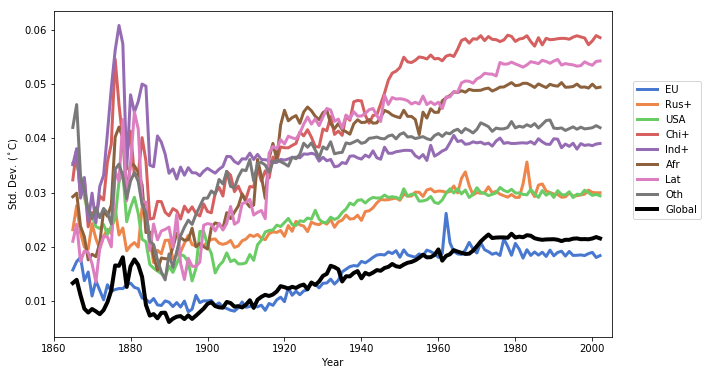

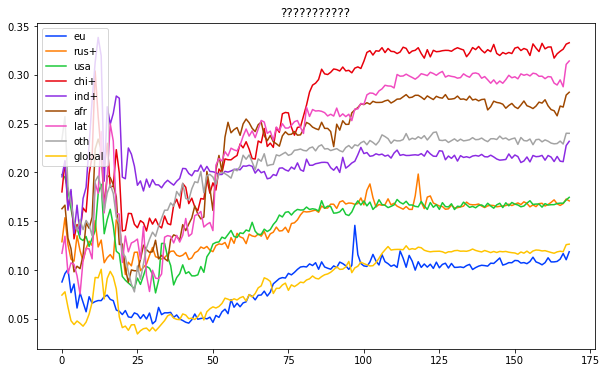

In [180]:
palette = sns.color_palette("muted", 8)
regionlabels = ['EU', 'Rus+', 'USA', 'Chi+', 'Ind+', 'Afr', 'Lat', 'Oth']


numanalysedyears = len(SDsOfSDs[0])
fig = plt.figure(figsize=(10,6))
for rgn in range(8):
    plt.plot(range((startyr + math.floor(climateperiod/2)), (endyr+1 - math.ceil(climateperiod/2))),SDsOfSDs[rgn], label = regionlabels[rgn], color=palette[rgn], linewidth=3)
plt.plot(range((startyr + math.floor(climateperiod/2)), (endyr+1 - math.ceil(climateperiod/2))),SDsOfSDs_global, label = 'Global', color='black', linewidth=4)
print(SDsOfSDs[:,:])
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.8), shadow=False, ncol=1)
# plt.title('Uncertainty on standard deviation of Annual Mean Temperature Variability') # using [uncertainty propagation]
plt.ylabel('Std. Dev. ($^\circ$C)')
plt.xlabel('Year')
plt.xlim([1860,2005])




fig2 = plt.figure(figsize=(10,6))
for rgn in range(8):
    plt.plot(range(numyears_data),SDsOfIlyas_regional[rgn], label = regions[rgn+1])
plt.plot(range(numyears_data),SDsOfIlyas_global, label = 'global')
print(SDsOfSDs[:,:])
plt.legend(loc = "best")
plt.title('???????????')


###
# conclusion seems to be that there is more of a spread in the recent decades
#   which indicates a higher spread in the amount of variability
#   and could therefore indicate a trend in the SD/NormDist of the interannual temperatures.

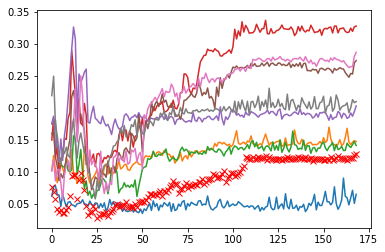

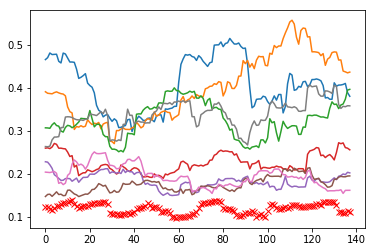

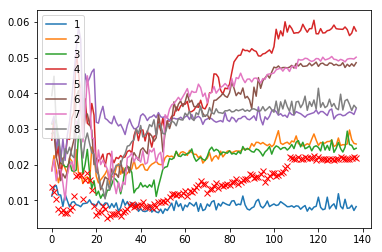

In [38]:
# print(regional_data_detrended)
for rgn in range(8):
    plt.figure(0)
    plt.plot(range(numyears_data),SDsOfIlyas_regional[rgn])
    plt.figure(1)
    plt.plot(range(numanalysedyears),SDsOfMEANs[rgn])
    plt.figure(2)
    plt.plot(range(numanalysedyears),SDsOfSDs[rgn])
    plt.legend(regions)
plt.figure(0)
plt.plot(range(numyears_data),SDsOfIlyas_global, 'rx')
plt.figure(1)
plt.plot(range(numanalysedyears),SDsOfMEANs_global, 'rx')
plt.figure(2)
plt.plot(range(numanalysedyears),SDsOfSDs_global, 'rx')

# print(SDsOfIlyas[3,:])
# print(SDsOfSDs[3,:])

###
# conclusion seems to be that there is more of a spread in the recent decades
#   which indicates a higher spread in the amount of variability
#   and could therefore indicate a trend in the SD/NormDist of the interannual temperatures.

# Main result

mean SD of eu: 0.40618267329976765
mean uncertainty on this SD is: 0.014898545811178384
mean SD of rus+: 0.39844713772817464
mean uncertainty on this SD is: 0.02569167372197046
mean SD of usa: 0.3252555272522722
mean uncertainty on this SD is: 0.02582205899190406
mean SD of chi+: 0.22547211679568047
mean uncertainty on this SD is: 0.043955820860928314
mean SD of ind+: 0.1843145894374979
mean uncertainty on this SD is: 0.03768244003481026
mean SD of afr: 0.17492734614386948
mean uncertainty on this SD is: 0.03853530112484564
mean SD of lat: 0.19497470468919498
mean uncertainty on this SD is: 0.039303404724419004
mean SD of oth: 0.3380869320481861
mean uncertainty on this SD is: 0.03596134736072164
global mean SD 0.11957976157382595
mean uncertainty on this SD is: 0.015009652970196742
Thus, subtracting the mean interannual SD of the global annual temperatures, the regions will have left:
mean SD of eu: 0.2866029117259417
mean SD of rus+: 0.2788673761543487
mean SD of usa: 0.2056757656784

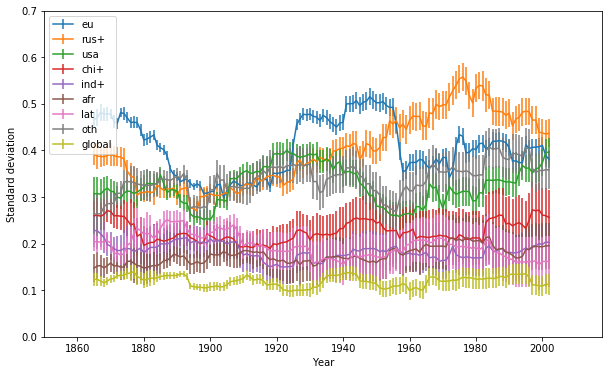

In [85]:
## plot SDs with uncertainty ranges:
fig = plt.figure(figsize=(10, 6))
for rgn in range(8):
    plt.errorbar(range((startyr + math.floor(climateperiod/2)), (endyr+1 - math.ceil(climateperiod/2))), regional_std[rgn, math.floor(climateperiod/2):(numyears_data - math.ceil(climateperiod/2))], SDsOfSDs[rgn], label = regions[rgn+1])
plt.errorbar(range((startyr + math.floor(climateperiod/2)), (endyr+1 - math.ceil(climateperiod/2))), global_std[math.floor(climateperiod/2):(numyears_data - math.ceil(climateperiod/2))], SDsOfSDs_global, label = 'global')
plt.xlim(startyr, endyr)
plt.ylim(0, 0.7)
# plt.title('Standard Deviations of Interannual mean temperature (detrended for 31-yr periods) with uncertainties')
plt.legend(loc = 'upper left')
plt.xlabel('Year')
plt.ylabel('Standard deviation')



    # print mean SDs
for rgn in range(numregions):
    print('mean SD of ' + str(regions[rgn+1]) + ': ' + str(np.nanmean(regional_std[rgn])))
    print('mean uncertainty on this SD is: ' + str(np.nanmean(SDsOfSDs[rgn])))
print('global mean SD' + ' ' + str(np.nanmean(global_std)))
print('mean uncertainty on this SD is: ' + str(np.nanmean(SDsOfSDs_global)))

print('Thus, subtracting the mean interannual SD of the global annual temperatures, the regions will have left:')
for rgn in range(numregions):
    print('mean SD of ' + str(regions[rgn+1]) + ': ' + str(np.nanmean(regional_std[rgn])-np.nanmean(global_std)))

(1860, 2005)

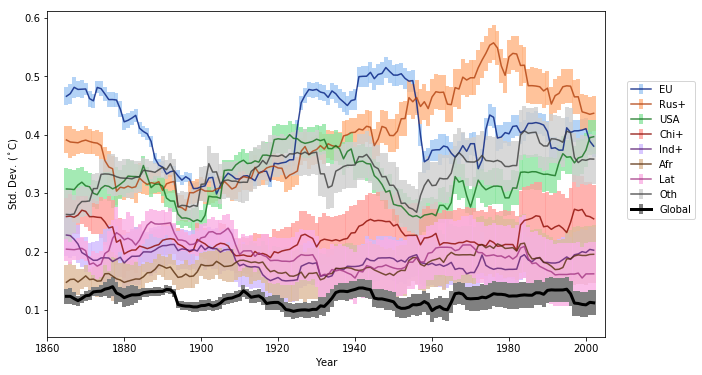

In [162]:
regionlabels = ['EU', 'Rus+', 'USA', 'Chi+', 'Ind+', 'Afr', 'Lat', 'Oth']

palette = sns.color_palette("dark", 8)
error_palette = sns.color_palette("pastel", 8)
## plot SDs with uncertainty ranges:
fig = plt.figure(figsize=(10, 6))
for rgn in range(8):
    plt.errorbar(range((startyr + math.floor(climateperiod/2)), (endyr+1 - math.ceil(climateperiod/2))), SDsOfMEANs[rgn], SDsOfSDs[rgn], label = regionlabels[rgn], color=palette[rgn], elinewidth=4, ecolor=error_palette[rgn], alpha=.8)
plt.errorbar(range((startyr + math.floor(climateperiod/2)), (endyr+1 - math.ceil(climateperiod/2))), SDsOfMEANs_global, SDsOfSDs_global, label = 'Global', color='black', ecolor='grey', elinewidth=4, linewidth=3)
plt.xlim(startyr, endyr)
plt.xlim(0, 0.7)
# plt.title('Standard Deviations of Interannual mean temperature (detrended for 31-yr periods) with uncertainties')
plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.8), shadow=False, ncol=1)
plt.xlabel('Year')
plt.ylabel('Std. Dev. ($^\circ$C)')
plt.xlim([1860,2005])

/home/ucfajsk/.conda/envs/pangeo/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


KeyError: None

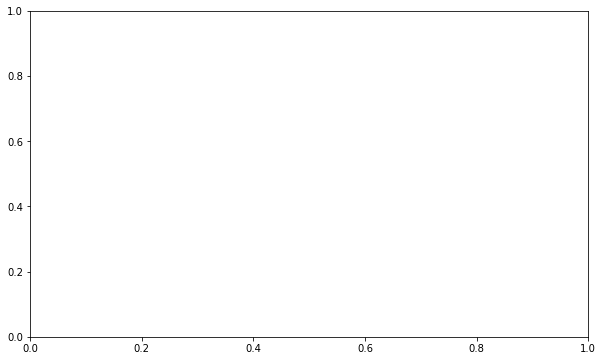

In [127]:


sns.set_palette("muted")
## plot SDs with uncertainty ranges:
fig, ax = plt.subplots(figsize=(10, 6))

x = range((startyr + math.floor(climateperiod/2)), (endyr+1 - math.ceil(climateperiod/2)))
y = SDsOfMEANs
std = SDsOfSDs
label = regions # index + 1

for rgn in range(8):
    plt.plot(x,y, 'k-')
    plt.fill_between(x,y-error)
    
    
    
    
    
#     df = pd.DataFrame.from_dict({
#         "mean": SDsOfMEANs[rgn],
#         "std": SDsOfSDs[rgn]
#     }).reset_index()
#     ax = sns.tsplot(df, err_style="std_band", n_boot=0)
#     g = sns.FacetGrid(df, size=6)
#     ax = g.map(plt.errorbar, "index", "mean", "std")
#     sns.tsplot(range((startyr + math.floor(climateperiod/2)), (endyr+1 - math.ceil(climateperiod/2))), SDsOfMEANs[rgn], SDsOfSDs[rgn], label = regions[rgn+1])
# plt.errorbar(range((startyr + math.floor(climateperiod/2)), (endyr+1 - math.ceil(climateperiod/2))), SDsOfMEANs_global, SDsOfSDs_global, label = 'global')
# plt.xlim(startyr, endyr)
# plt.xlim(0, 0.7)
# # plt.title('Standard Deviations of Interannual mean temperature (detrended for 31-yr periods) with uncertainties')
# plt.legend(loc='upper center', bbox_to_anchor=(1.1, 0.8), shadow=False, ncol=1)
# plt.xlabel('Year')
# plt.ylabel('Standard deviation')
# plt.xlim([1860,2005])

## [not yet working] Calculating SD the crude way:
#### assuming that each MC member is dependent.

In [42]:
# note: 30 datasets need to be open at every instance for this way of calculating uncertainties....
def crude_loop_over_ensmembers():
    dsdir = '/data/aod/Ilyasetal2017_annual/wrt_18501900/'
    
    # load first file to get dimensions:
    dsname = '%s.ann_ensmem.wrt18501900.nc' % (1850)
    print(dsname)

    DS = xr.open_dataset(dsdir + dsname)
    t_anom_ds = DS.temperature_anomaly     # yearly data; [10000 x 1 x 36 x 72], float32
    t_anom = t_anom_ds.values

    nummembers = t_anom.shape[0]
    lats = t_anom.shape[2]
    lons = t_anom.shape[3]
    SDgrid = np.zeros((numyears_data, lats, lons))
    print(t_anom.shape)
    print(SDgrid.shape)
    print(lats, lons)
        
    memberscalculated = 50 # to prevent overload
    
    # define storage variables
    interannualSDlist = np.zeros((memberscalculated, numregions)) # interannual SD per year for all members
    SDofSDlist = np.zeros(((numyears_data - climateperiod), numregions)) # final outcome = average of interannualSDlist for all years
       
    
    
    
    for yr in range(numyears_data - climateperiod):
        print(yr)
        # create one big list with
        # if all t : load 30 files [because detrending needs to happen every time]
        datafiles_detrended = np.zeros((climateperiod, memberscalculated, numregions))
        
        #t_anom_1 = np.zeros((nummembers, numyears_data, lats, lons)) # for reading in a yearly datafile with uncertainty members
        
        save_t_anom_regionally_processed_30 = np.zeros((climateperiod, memberscalculated, numregions)) # 
        
        for fileyr in range(climateperiod): ### ---> takes 1s per loop for 10 members [1h+ for 10 members] ==> 30 x 137 x 1000 = 1141 hours = 47.5 days
            datayr = fileyr + startyr + yr

            dsname = '%s.ann_ensmem.wrt_18501900.nc' % (datayr)
            DS = xr.open_dataset(dsdir + dsname)
            t_anom_ds = DS.temperature_anomaly     # yearly data; [10000 x 1 x 36 x 72], float32            
            t_anom_1 = t_anom_ds.values
            # make regional for each member
            for m in range(memberscalculated):
                save_t_anom_regionally_processed_30[fileyr, m] = np.squeeze(do_regional_data(t_anom_1[m]))
                


        # detrend regionally for each member -- all below is relatively fast, compared to above.
        for m in range(memberscalculated):
            for rgn in range(numregions):
                fit = np.polyfit(list(range(climateperiod)), save_t_anom_regionally_processed_30[:, m, rgn], 1)    
                f = np.poly1d(fit)  
                datafiles_detrended[:, m, rgn] = save_t_anom_regionally_processed_30[:, m, rgn] - f(list(range(climateperiod)))
        # for each member: calculate interannual sd
        for m in range(memberscalculated):
            for rgn in range(numregions):
                interannualSDlist[m, rgn] = np.std(datafiles_detrended[:,m,rgn])

        ### take the average over all members and store this for t=yr.
        for rgn in range(numregions):
            SDofSDlist[yr,rgn] = np.mean(interannualSDlist[:,rgn])


    return SDofSDlist, interannualSDlist
                
                
               
            

            
             
            
        
        
        
            
SDofSDlist, interannualSDlist = crude_loop_over_ensmembers()            
            

1850.ann_ensmem.wrt18501900.nc
(10000, 1, 36, 72)
(167, 36, 72)
36 72
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136


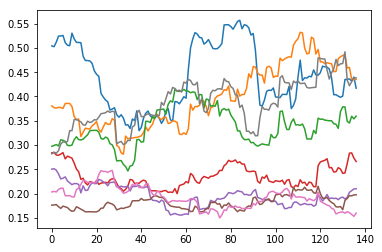

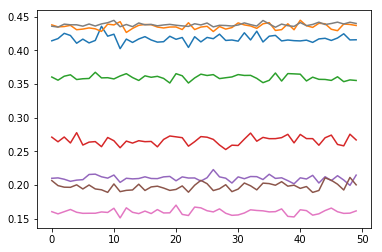

In [46]:
plt.figure()
for rgn in range(8):
    plt.plot(range(139), SDofSDlist[:,rgn])

plt.figure()
for rgn in range(8):
    plt.plot(range(50),interannualSDlist[:,rgn])
    
# plt.figure()
# for rgn in range(8):
#     plt.errorbar(range((startyr + math.floor(climateperiod/2)), (endyr+1 - math.ceil(climateperiod/2))), regional_std[rgn, math.floor(climateperiod/2):(numyears_data - math.ceil(climateperiod/2))], SDofSDlist[:,rgn], label = regions[rgn+1])
# plt.xlim(startyr, endyr)
# plt.title('Standard Deviations of Interannual mean temperature (detrended periods of 30-yrs) with uncertainties')
# plt.legend(loc = 'upper left')
# plt.xlabel('Year')
# plt.ylabel('Standard deviation')

In [181]:
x = do_regional_data(t_anom)

[[0.50582126 0.35542984 0.39263095 0.52738073 0.44629214]
 [0.35930891 0.29469786 0.30856833 0.46175231 0.47233378]
 [0.28457631 0.25301135 0.40644272 0.30305055 0.35282822]
 [0.26721364 0.2094907  0.22030021 0.23915046 0.26346581]
 [0.2294372  0.20777163 0.15706974 0.19945155 0.19234955]
 [0.14883212 0.15909984 0.15971276 0.18928398 0.20071216]
 [0.20601861 0.2191961  0.18338169 0.18009577 0.18498269]
 [0.28482973 0.29820034 0.41532991 0.32231849 0.47854382]]


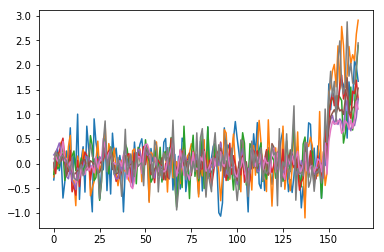

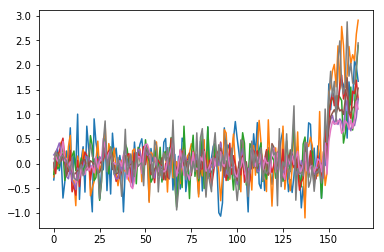

In [185]:
for i in range(8):    
    plt.plot(range(169), x[i])
    
for rgn in range(numregions):
    for k in range(5):
        fit = np.polyfit(list(range(climateperiod)), x[rgn, k*climateperiod:k*climateperiod+climateperiod], 1)    
        f = np.poly1d(fit)  
        x[rgn, k*climateperiod:k*climateperiod+climateperiod] = x[rgn, k*climateperiod:k*climateperiod+climateperiod] - f(list(range(climateperiod)))
        
plt.figure()
for i in range(8):    
    plt.plot(range(169), x[i])
    
interannualSDlist = np.zeros((numregions,5))
for rgn in range(numregions):
    for k in range(5):
        interannualSDlist[rgn,k] = np.std(x[rgn, k*climateperiod:k*climateperiod+climateperiod])
        
print(interannualSDlist)


In [81]:
print(SDsOfSDs[0].shape)

(137,)


In [92]:
print(startyr + math.floor(climateperiod/2))
print(endyr+1 - math.ceil(climateperiod/2))
print(len(range((startyr + math.floor(climateperiod/2)), (endyr+1 - math.ceil(climateperiod/2)))))
print(regional_std[rgn].shape)
print(SDsOfSDs[rgn].shape)

1865
2002
137
(167,)
(137,)


# BELOW: old code for possible future reference.

## N.B. the code below should not be used as it is now 

# To-do list:
#### !!!) DETREND FOR 'moving 30yr frame' regional (linear) TEMPERATURE TREND (NB. this is not similar to 'anthropogenic warming', but should capture interannual variability)
#### 1) check splitting up for nan (var) and not nan (mean)
#### 2) check why e.g. t_anom_mean becomes smaller --> how to deal with end of data, selecting the range.
##### --> ESPECIALLY SINCE VARIANCE SUDDENLY DECREASES IN THE LAST 15 YEARS, unexpectedly?
#### .) extend annual data for the entire range, beyond climatic data.
Stuff to still do in later stages:
1) use pandas rather than a m-dimension array
2) ...
3) ...

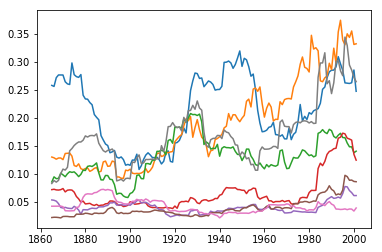

In [141]:
# NOTE:
## FOR NOW, i have just quickly taken the regional_data_detrended and put them into the place of the 
## old regional_data
# ALSO NOTE:
## the global data should also have been detrended now
def do_analysis(regional_data, regional_data_notdetrended, data): # data just for shape, again, change later when cleaning code (t_anom is accessible globally)
    # analysis parameters
    climateperiod = 30 # climatological period over which the interannual variability is determined
    analysis_range = [startyr + int(climateperiod/2), endyr - int(climateperiod/2)]
    analysis_duration = data.shape[0] - climateperiod
    
    
    
    # regional variables
    variance_matrix = np.zeros((len(regions), analysis_duration)) # always climatic [over climateperiod]
    rmt_clim_matrix = np.zeros((len(regions), analysis_duration))
    rmt_clim_matrix_notdetrended = np.zeros((len(regions), analysis_duration))
    rmt_ann_matrix = np.zeros((len(regions), analysis_duration))
    
    # global (all of the globe) variables
    gmt_clim_matrix = np.zeros(analysis_duration)
    gmt_clim_matrix_notdetrended = np.zeros(analysis_duration)
    gmt_ann_matrix = np.zeros(analysis_duration)
    variance_matrix_global = np.zeros(analysis_duration) # always climatic [over climateperiod]
    
    # global (over land) variables
    land_clim_matrix = np.zeros(analysis_duration)
    land_clim_matrix_notdetrended = np.zeros(analysis_duration)
    land_ann_matrix = np.zeros(analysis_duration)
    variance_matrix_land = np.zeros(analysis_duration) # always climatic [over climateperiod]
    
    # data storages variables -- gmt_mean[yr]
    t_anom_mean = np.zeros(169)
    t_anom_mean_land = np.zeros(169)
    detrended_global_means = np.zeros(169)
    detrended_land_means = np.zeros(169)
    for year in range(169):
        detrended_global_means[year] = np.mean(data[year]) - g_temperaturetrend[year]
        for c in regions: # run over all regions
            c = c - 1
            detrended_land_means[year] = np.mean(regional_data[:,year]) - g_temperaturetrend[year]
            
    for year in range(169):
    # note that this should be data for 1865-2001 --- print(analysis_range) -- CHECK: range
        # global mean temperatures
        t_anom_mean[year] = detrended_global_means[year]
        t_anom_mean_land[year] = np.mean(regional_data[:, year])
    
    

    for c in regions: # run over all regions
        c = c - 1
#         for year in range(167): # run over all years
            # apply weighting
            # regional_data[c][year] = np.nanmean(np.multiply(data[year], weighted_grid[c])) # t[year] * weighted_mask
            ## above is an incorrect way --> every point needs to be weighted differently in the mean...
                         
        # VARIANCE
        for year in range(analysis_duration): # note that this should be data for 1865-2001 --- print(analysis_range)
            # Returns the variance of the array elements, a measure of the spread of a distribution.
            variance_matrix[c][year] = np.var(regional_data[c,(year):(year+int(climateperiod))]) # calculate variance for 30 years around 'year'
                    
        # TEMPERATURE
            # calculate regional mean temperature [rmt] (over climateperiod)
#         for year in range(analysis_duration):    
            rmt_ann_matrix[c][year] = regional_data[c][year]
            rmt_clim_matrix[c][year] = np.mean(regional_data[c,(year):(year+int(climateperiod))]) # calculate rmt for 30 years around 'year'
            rmt_clim_matrix_notdetrended[c][year] = np.mean(regional_data_notdetrended[c,(year):(year+int(climateperiod))])
        
        
    for year in range(analysis_duration): 

        # calculate global mean temperature variance || calculate mean temperature variance over land
        variance_matrix_global[year] = np.var(t_anom_mean[(year):(year+int(climateperiod))]) # calculate gmt for 30 years around 'year'
        variance_matrix_land[year] = np.var(t_anom_mean_land[(year):(year+int(climateperiod))])
        
        # calculate global mean temperature || calculate mean temperature over land
        gmt_ann_matrix = t_anom_mean # is for the entire data period (167 yrs)
        gmt_clim_matrix[year] = np.mean(t_anom_mean[(year):(year+int(climateperiod))]) # calculate gmt for 30 years around 'year'
        gmt_clim_matrix_notdetrended[year] = np.mean(data[year])
        land_ann_matrix[year] = np.mean(regional_data[:, year]) # could extend for all of the data period, now just for (137 yrs)
        land_clim_matrix[year] = np.mean(regional_data[:,(year):(year+int(climateperiod))])           
        land_clim_matrix_notdetrended[year] = detrended_land_means[year] + g_temperaturetrend[year]                                     
                                              
            
            # calculate ...

            
    return variance_matrix, rmt_clim_matrix, rmt_ann_matrix, gmt_ann_matrix, gmt_clim_matrix, variance_matrix_global, variance_matrix_land, land_ann_matrix, land_clim_matrix, t_anom_mean, rmt_clim_matrix_notdetrended, gmt_clim_matrix_notdetrended, land_clim_matrix_notdetrended

# running the function and taking the output
variance_matrix, rmt_clim_matrix, rmt_ann_matrix, gmt_ann_matrix, gmt_clim_matrix, variance_matrix_global, variance_matrix_land, land_ann_matrix, land_clim_matrix, t_anom_mean, rmt_clim_matrix_notdetrended, gmt_clim_matrix_notdetrended, land_clim_matrix_notdetrended = do_analysis(regional_data_detrended, regional_data, t_anom)
# print(regional_data, variance_matrix, rmt_clim_matrix, rmt_ann_matrix, gmt_ann_matrix, gmt_clim_matrix, variance_matrix_global, variance_matrix_land, land_ann_matrix, land_clim_matrix)    
for i in range(8):
    plt.plot(range(1865,2002), variance_matrix[i,:])


#### Find statistical representations (per region)

In [137]:
# Step 1a, 1b, 1c.: best fit line [a. v = constant b. v = at+b, b. v = at^2+bt+c]

#### Plotting the results coming from above analysis

Climatic RMT --> RMT variance eu [4.12324752e-01 5.54343641e-07]
Climatic RMT --> RMT variance rus+ [8.31365393e-01 2.95792412e-36]
Climatic RMT --> RMT variance usa [7.27999515e-01 6.89790655e-24]
Climatic RMT --> RMT variance chi+ [4.88747736e-01 1.36649862e-09]
Climatic RMT --> RMT variance ind+ [0.15310266 0.07407547]
Climatic RMT --> RMT variance afr [7.37081599e-01 9.80863835e-25]
Climatic RMT --> RMT variance lat [-3.39341386e-01  4.98061581e-05]
Climatic RMT --> RMT variance oth [6.60625945e-01 1.58915524e-18]


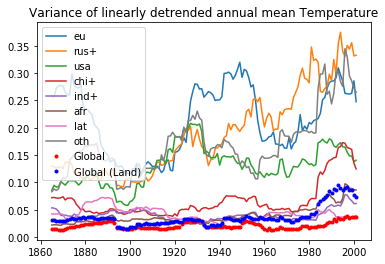

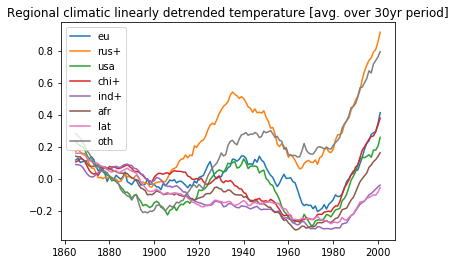

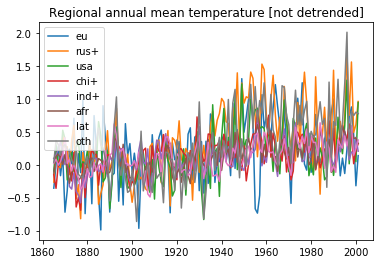

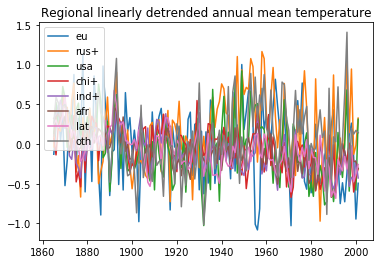

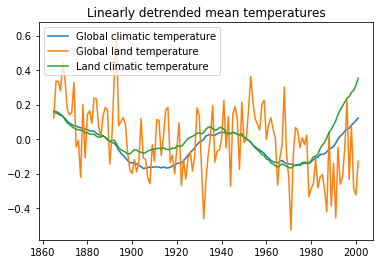

In [145]:
#############
# VARIANCE
#############
# plotting running variance for the different regions:
plt.figure()
for i in range(1,len(regions)+1):
    plt.plot(list(range(1865,2002)),variance_matrix[i-1,:], label = regions[i])  ### is not responding to detrending
plt.title('Variance of linearly detrended annual mean Temperature')

# plotting running global variance:
plt.plot(list(range(1865,2002)), variance_matrix_global, 'r.', label = 'Global')
plt.legend(loc='upper left')
plt.plot(list(range(1865,2002)), variance_matrix_land, 'b.', label = 'Global (Land)')
plt.legend(loc='upper left')



#############
# TEMPERATURE
#############
# plotting average climatic regional temperature anomalies:
plt.figure()
for i in range(1,len(regions)+1):
    plt.plot(list(range(1865,2002)), rmt_clim_matrix[i-1,:], label = regions[i]) 
plt.title('Regional climatic linearly detrended temperature [avg. over 30yr period]')
plt.legend(loc='upper left')
# for control, plot the yearly temperatures:
rmt_ann_matrix_notdetrended = np.zeros(rmt_ann_matrix.shape)
for c in regions: # run over all regions
        c = c - 1
        for year in range(139):     
            rmt_ann_matrix_notdetrended[c][year] = regional_data[c][year]
plt.figure()
for i in range(1,len(regions)+1):
    plt.plot(list(range(1865,2002)), rmt_ann_matrix_notdetrended[i-1,:], label = regions[i])
plt.title('Regional annual mean temperature [not detrended]')
plt.legend(loc='upper left')
plt.figure()
for i in range(1,len(regions)+1):
    plt.plot(list(range(1865,2002)), rmt_ann_matrix[i-1,:], label = regions[i])
plt.title('Regional linearly detrended annual mean temperature')
plt.legend(loc='upper left')
# global yearly temperatures with the climatic temperature overlayed:
plt.figure() 
plt.plot(list(range(1865,2002)), gmt_clim_matrix, label = 'Global climatic temperature')
plt.plot(list(range(1865,2002)), land_ann_matrix, label = 'Global land temperature')      
plt.plot(list(range(1865,2002)), land_clim_matrix, label = 'Land climatic temperature')
plt.title('Linearly detrended mean temperatures')
plt.legend(loc='upper left')

    
    
    
###### ALLLL OF THE BELOW SHOULD BE REVISED, RESULTS DON'T MAKE SENSE (e.g. detrended land temperature should not go down, p-values still too low, etc.)    
    # find the correlations: reg_variance = f(rmt) || reg_variance = f(gmt) || global(all)_variance = f(gmt)
            # stats.spearmanr(A,B) -- takes: two arrays -- returns: correlation, p-value
corrNp_rmt_var = np.zeros((len(regions),2))
corrNp_gmt_var = np.zeros((len(regions),2))
corrNp_gmt_gmtvar = np.zeros(2)
for i in regions:
    i = i-1
    corrNp_rmt_var[i] = stats.spearmanr(rmt_clim_matrix_notdetrended[i,:], variance_matrix[i,:])
    corrNp_gmt_var[i] = stats.spearmanr(gmt_clim_matrix_notdetrended[:], variance_matrix[i,:])
corrNp_gmt_gmtvar[:] = stats.spearmanr(gmt_clim_matrix_notdetrended[:], variance_matrix_global[:])

for i in regions:
    print('Climatic RMT --> RMT variance', regions[i], corrNp_rmt_var[i-1])
    #print('Climatic GMT --> RMT variance', regions[i], corrNp_gmt_var[i-1])
# print('Climatic GMT --> GMT variance',corrNp_gmt_gmtvar)
##########################
# first conclusions:
## 1) 'ind+' and 'lat' do not have significant p-values
## 2) otherwise, the relation with GMT and RMT is pretty similar for each region.
## 3) correlations are mostly in the range of 0.4-0.9
## 4) --- perhaps note that linear detrending underestimates global warming trend in the most recent decades

#### To be worked on::::

### For Multiple Ensemble Members --- including uncertainty

In [164]:
# using netCDF4.Dataset
for i in range(startyr, startyr + 1):
    # location of the Ilyas2017 data files
    location = '/data/aod/Ilyasetal2017_annual/wrt_18501900/' + str(i) + '.ann_ensmem.wrt_18501900.nc'
    
    # reading in data  - using netCDF4.Dataset 
    dataset = Dataset(location)
    print(dataset.variables)

# using xarray - in one go:
dsdir = '/data/aod/Ilyasetal2017_annual/wrt_18501900/*.ann_ensmem.wrt_18501900.nc'
DS = xr.open_mfdataset(dsdir)
## HOWEVER ## then transforming to np.array using da = DS.values would take ages.

OrderedDict([('latitude', <class 'netCDF4._netCDF4.Variable'>
float64 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (36,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('longitude', <class 'netCDF4._netCDF4.Variable'>
float64 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (72,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('temperature_anomaly', <class 'netCDF4._netCDF4.Variable'>
float32 temperature_anomaly(ens_mem, time, latitude, longitude)
    units: celsius
    long_name: near_surface_temperature_anomaly
    cell_methods: time: mean
    baseline: 1850-1900
unlimited dimensions: ens_mem
current shape = (10000, 1, 36, 72)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('time', <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: months
    long_name: time
    cell_methods: time: mean
unlimited dime

In [31]:
# extract data array temperature_anomaly [1000 x 167 x 36 x 72]
t_anom_ds = DS.temperature_anomaly
#t_anom_da = t_anom_ds.values # --> change from xr.array/dataset to numpy.arry 

# BELOW: redundant code

    ###########
    # all what is below seems redundant now;
    ## old linear rounding scaling
    ###########
    
    
    
# function to apply the mask in later code
# grid = temperature (or other data) that needs to be masked
# region = input as either 1-8 or 'eu'-'oth'
# mask = original 180 x 360 masking file.
def apply_mask(grid, region, mask):
    
    # simple scaling to coarser map 
    if ((grid.shape[0]<mask.shape[0]) and (grid.shape[1]<mask.shape[1])): # if mask is finer than grid
        new_mask = np.zeros(grid.shape)
        for i in range(grid.shape[0]): # latitude
            for j in range(grid.shape[1]): # longitude
                iratio_simple = mask.shape[0]/grid.shape[0]
                jratio_simple = mask.shape[1]/grid.shape[1]
                
                i_low = math.floor(i * iratio_simple)
                i_high = math.ceil(i * iratio_simple)
                j_low = math.floor(j * jratio_simple)
                j_high = math.ceil(j * jratio_simple)
                
                
                i_weight = (i * iratio_simple)%1
                j_weight = (j * jratio_simple)%1
                
                number_to_assign = (i_low*(1-i_weight) + i_high*i_weight)/2 + (j_low*(1-j_weight) + j_high*j_weight)/2
                
                iratio_weight = 1
                
                new_mask[i][j] = mask[round(i * iratio_simple)][round(j * jratio_simple)]
        mask = new_mask
        #####
        # is there an elegant way to deal with shitty scaling/having a very coarse grid?? 
        #####
        
    
    #plt.contourf(mask)
    
    masked_grid = np.zeros(grid.shape)
    
    # do stuff that is in dopagemask.nc
    for i in range(grid.shape[0]): # latitude
        for j in range(grid.shape[1]): # longitude

            if region == (regions[1] or 1):
                if mask[i][j] == 1:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan
            if region == (regions[2] or 2):
                if mask[i][j] == 2:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan
            if region == (regions[3] or 3):
                if mask[i][j] == 3:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan
            if region == (regions[4] or 4):
                if mask[i][j] == 4:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan
            if region == (regions[5] or 5):
                if mask[i][j] == 5:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan
            if region == (regions[6] or 6):
                if mask[i][j] == 6:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan
            if region == (regions[7] or 7):
                if mask[i][j] == 7:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan
            if region == (regions[8] or 8):
                if mask[i][j] == 8:
                    masked_grid[i][j] = grid[i][j]
                else:
                    masked_grid[i][j] = np.nan

    return masked_grid     

In [ ]:
#################################################
# OLD (redundant?) code for detrending
#################################################


#     # routine for detrending:
#     t_anom_mean = np.zeros(numyears_data)
#     t_anom_mean_land = np.zeros(numyears_data)
#     for year in range(numyears_data):
#         t_anom_mean[year] = np.mean(data[year])
#         t_anom_mean_land[year] = np.mean(regional_data[:,year])   
#     ## options for detrending: 
#     # 1. linear
#     # 2. quadratic
#     ## more options for detrending:
#     # a. global mean T data: t_anom = np.mean(data[year])
#     # b. global land mean T data: np.mean(regional_data[:,year])
#     fit_linear = np.polyfit(range(numyears_data), t_anom_mean, 1)
#     print(fit_linear)
#     f = np.poly1d(fit_linear)
#     xrange = range(1850, (1850+numyears_data) )
#     plt.plot(xrange, t_anom_mean, '.', xrange, f(range(numyears_data)))
#     plt.title('GMT with quadratic trend in mean temperature over land')
    
#     g_temperaturetrend = np.zeros(data.shape[0]) # will become a linear array of temperature increase
#     for year in range(numyears_data):
#         g_temperaturetrend[year] = f(year)
    
#     for c in regions:
#         c = c-1
#         regional_data_detrended[c] = regional_data[c] - g_temperaturetrend
        
# #     # NOW for regional detrending:
# #     g_temperaturetrend_regional = np.zeros((len(regions),data.shape[0]) # will become a linear array of temperature increase
# #     for year in range(167):
# #         g_temperaturetrend[year] = f(year)
    
# #     for c in regions:
# #         c = c-1
# #         fit_linear = np.polyfit(range(167), np.mean(regional_data[c,year]), 1)
# #         f = np.poly1d(fit_linear)
# #         g_temperaturetrend_regional[c] = f(year)
# #         regional_data_detrended[c] = regional_data[c] - g_temperaturetrend

#     # do a little check:
#     plt.figure()
#     plt.plot(xrange, t_anom_mean, '.', xrange, regional_data_detrended[0])
    
#     return regional_data, regional_data_detrended, g_temperaturetrend

# regional_data, regional_data_detrended, g_temperaturetrend = do_regional_data(t_anom) # TAKES REALLY LONG?
    
# plt.figure()
# for i in range(8):
#     plt.plot(range(1850,2017), regional_data_detrended[i])